# Taxi trips count prediction

The task is to create a model that predicts the count of taxi trips for the next hour in [Chicago's community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago).  
  
Links to the datasets:  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb

## Load libraries and data

In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import Imputer
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format, col, count, countDistinct, date_trunc, isnull, lag
from pyspark.sql.functions import max as spark_max
from pyspark.sql.functions import median, mode
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import to_timestamp, when
from pyspark.sql.window import Window
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm

from lib.time_series_processing import TSDataManager

In [2]:
!pip install -r requirements.txt

from catboost import CatBoostRegressor
import lightgbm as lgb

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '-q'


In [3]:
import numpy as np

np.random.seed(42)

In [4]:
plt.style.use("fivethirtyeight")
plt_params = {
    "axes.titlesize": "18",
    "axes.labelsize": "15",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": "13",
    "ytick.labelsize": "13",
    "legend.fontsize": "13",
    "lines.linewidth": "2.0",
}

plt.rcParams.update(plt_params)

In [5]:
warnings.simplefilter("ignore")

In [6]:
# reload modules before execution

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
APP_NAME = "taxi"
SPARK_MASTER_IP = "172.18.0.2"

PAYMENT_TYPE_THRESHOLD = 1000
TAXI_COMPANY_THRESHOLD = 100
TEST_SIZE = 0.15
START_DATE = "2022-01-08"  # we use trips count with 1 week lag

In [9]:
spark = (
    SparkSession.builder.appName(APP_NAME)
    .config("spark.sql.repl.eagerEval.enabled", True)
    .master(f"spark://{SPARK_MASTER_IP}:7077")
    .config("spark.executor.cores", 2)
    .config("spark.task.cpus", 2)
    .config("spark.executor.memory", "3g")
    .getOrCreate()
)

In [10]:
taxi_2022 = spark.read.load("data/trips_2022.csv", format="csv", header="true", inferSchema="true")

In [11]:
taxi_2023 = spark.read.load("data/trips_2023.csv", format="csv", header="true", inferSchema="true")

## Data cleaning

First step is to remove illogical and erroneous values in data, as well as to delete redundant columns.

In [12]:
taxi_2022.columns

['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid  Location']

Converting the trip data to datetime format and removing excessive trips:

In [13]:
taxi_2022 = taxi_2022.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2022 = taxi_2022.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-01-01")

In [14]:
taxi_2023 = taxi_2023.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2023 = taxi_2023.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-08-01")

Joining data for 2022/2023 and removing columns with useless information:

In [15]:
taxi = taxi_2022.union(taxi_2023)

In [16]:
taxi = taxi.drop(*["Pickup Centroid Location", "Dropoff Centroid  Location", "Trip ID", "Trip End Timestamp"])

### Money features

*Hereinafter EDA code is commented out to speed up the data processing with Spark.*  
  
Remove rows where total cost of trip differs significantly from the sum of payments:

In [17]:
# number of rows where Trip total differs more than by 3 dollars from sum
# taxi.filter(taxi['Trip Total'] - (taxi['Fare'] + taxi['Tips'] + taxi['Tolls'] + taxi['Extras']) > 3).count()
# 412

In [18]:
taxi = taxi.filter(taxi["Trip Total"] - (taxi["Fare"] + taxi["Tips"] + taxi["Tolls"] + taxi["Extras"]) < 3)

### Time and distance features

* Add a new feature (**Mean Speed**).   
* Remove entries where mean speed is more than 70 mph, as this is the speed limit in Chicago and its proximity.

In [19]:
taxi = taxi.withColumn("Mean Speed", col("Trip Miles") / (col("Trip Seconds") / 3600))

In [20]:
# taxi.filter(col("Mean Speed") > 70).count()
# 12359

In [21]:
taxi = taxi.filter(col("Mean Speed") <= 70)

### Categorial features

Remove rows with rare company or payment type.

In [22]:
# taxi.agg(countDistinct(col('Taxi ID')))
# taxi.agg(countDistinct(col('Company')))

In [23]:
company_counts = taxi.groupBy("Company").count()
filtered_companies = company_counts.filter(company_counts["count"] < TAXI_COMPANY_THRESHOLD)
companies_to_drop = filtered_companies.select("Company")	

In [24]:
taxi = taxi.join(companies_to_drop, on="Company", how="left_anti")

In [25]:
payment_type_counts = taxi.groupBy("Payment Type").count()
filtered_payment_types = payment_type_counts.filter(payment_type_counts["count"] < PAYMENT_TYPE_THRESHOLD)
payment_types_to_drop = filtered_payment_types.select("Payment Type")

In [26]:
taxi = taxi.join(payment_types_to_drop, on="Payment Type", how="left_anti")

## Data processing

In order to predict values for the next hour in a given community area, the data needs to be properly transformed.  
First, the gaps will be filled, then the following transformations will be performed for the dataset features:

* [x] `Latitudes / Longitudes`: drop
* [x] `Taxi ID`: unique taxi ids for the current hour and current community area  
* [x] `Pickup / Dropoff census tract`: unique count
* [x] `Trip seconds`: aggregate, median  
* [x] `Trip miles`: aggregate, median  
* [x] `Money factors`: aggregate, median  
* [x] `Census tracts`: mode
* [x] `Payment type / Company`: frequency of values within an hour

Feature engineering:  
* [x] Trips count and trip total rolling mean and lags
* [x] Time features (dow, hour)

### Gaps

For missing community areas, use the value 100:

In [27]:
taxi = taxi.fillna(100, subset=["Pickup Community Area"])
taxi = taxi.fillna(100, subset=["Dropoff Community Area"])

Before imputation, save geo features for 2023 for further investigation.

In [28]:
geo_features_pickup = taxi.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") >= "2023-01-01").select(
    "Pickup Community Area",
    "Pickup Census Tract",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
)

In [29]:
MULTIPLIER = 1.001

In [30]:
# show columns with gaps
# taxi.select([count(when(isnull(c), c)).alias(c) for c in taxi.columns])

For missing latitude / longitude / census tract, use the max value in the feature column, multiplied by 1.001:

In [31]:
max_values = taxi.select(
    spark_max(col("Pickup Centroid Latitude")).alias("max_pc_lat"),
    spark_max(col("Pickup Centroid Longitude")).alias("max_pc_lon"),
    spark_max(col("Dropoff Centroid Latitude")).alias("max_dc_lat"),
    spark_max(col("Dropoff Centroid Longitude")).alias("max_dc_lon"),
    spark_max(col("Pickup Census Tract")).alias("max_pcm"),
    spark_max(col("Dropoff Census Tract")).alias("max_dcm"),
).first()

In [32]:
max_pc_lat = max_values["max_pc_lat"] * MULTIPLIER
max_pc_lon = max_values["max_pc_lon"] * MULTIPLIER
max_dc_lat = max_values["max_dc_lat"] * MULTIPLIER
max_dc_lon = max_values["max_dc_lon"] * MULTIPLIER

max_pcm = round(max_values["max_pcm"] * MULTIPLIER)
max_dcm = round(max_values["max_dcm"] * MULTIPLIER)

In [33]:
taxi = taxi.fillna(max_pc_lat, subset=["Pickup Centroid Latitude"])
taxi = taxi.fillna(max_pc_lon, subset=["Pickup Centroid Longitude"])
taxi = taxi.fillna(max_dc_lat, subset=["Dropoff Centroid Latitude"])
taxi = taxi.fillna(max_dc_lon, subset=["Dropoff Centroid Longitude"])

taxi = taxi.fillna(max(max_pcm, max_dcm), subset=["Pickup Census Tract", "Dropoff Census Tract"])

For money features, impute the missing values with median value in column.

In [34]:
columns_to_fill = [
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
]

# this approach is a bit unfair, as we can't know the values for test data in real setting
# this will unsignificantly improve the final metric
imputer = Imputer(inputCols=columns_to_fill, outputCols=columns_to_fill).setStrategy("median")
taxi = imputer.fit(taxi).transform(taxi)

### Aggregating non-time features

Group by hour and location, then create unique, aggregate, median, mode and frequency features.

In [35]:
grouped = taxi.groupBy(
    date_trunc("hour", col("Trip Start Timestamp")).alias("date"), col("Pickup Community Area").alias("location")
)

#### Data transformation

##### distinct

In [36]:
agg_1_distinct = grouped.agg(
    countDistinct(col("Taxi ID")).alias("taxi_id_count_unique"),
    countDistinct(col("Pickup Census Tract")).alias("pickup_census_count_unique"),
    countDistinct(col("Dropoff Census Tract")).alias("dropoff_census_count_unique"),
)

##### sum and median

In [37]:
agg_2_sum_and_median = grouped.agg(
    spark_sum(col("Trip Seconds")).alias("trip_seconds_agg"),
    median(col("Trip Seconds")).alias("trip_seconds_median"),
    spark_sum(col("Trip Miles")).alias("trip_miles_agg"),
    median(col("Trip Miles")).alias("trip_miles_median"),
    spark_sum(col("Tips")).alias("tips_agg"),
    median(col("Tips")).alias("tips_median"),
    spark_sum(col("Fare")).alias("fare_agg"),
    median(col("Fare")).alias("fare_median"),
    spark_sum(col("Tolls")).alias("tolls_agg"),
    median(col("Tolls")).alias("tolls_median"),
    spark_sum(col("Extras")).alias("extras_agg"),
    median(col("Extras")).alias("extras_median"),
    spark_sum(col("Trip Total")).alias("trip_total_agg"),
    median(col("Trip Total")).alias("trip_total_median"),
    median(col("Mean Speed")).alias("mean_speed_median"),
)

##### mode

In [38]:
agg_3_mode = grouped.agg(
    mode(col("Pickup Census Tract")).alias("pickup_census_mode"),
    mode(col("Dropoff Census Tract")).alias("dropoff_census_mode"),
)

##### frequency

In [39]:
companies = company_counts.select("Company").collect()
payment_types = payment_type_counts.select("Payment Type").collect()

In [40]:
# this code calculates frequencies of occurrence of every unique company
company_frequencies = grouped.agg(
    *[
        (
            spark_sum((col("Company") == company[0]).cast("int"))  # count of non-zero entries for selected payment type
            / count(col("Company"))  # count of all entries
        ).alias(f"company_{company[0].lower()}")
        for company in companies
    ]
)

In [41]:
payment_type_frequencies = grouped.agg(
    *[
        (
            spark_sum((col("Payment Type") == payment_type[0]).cast("int")) 
            / count(col("Payment Type"))
        ).alias(f"payment_{payment_type[0].lower()}")
        for payment_type in payment_types
    ]
)

#### Joining features and creating lag

Join the transformed features and create lag by 1 hour:

In [42]:
total = company_frequencies.join(payment_type_frequencies, ["date", "location"])
total = total.join(agg_1_distinct, ["date", "location"])
total = total.join(agg_2_sum_and_median, ["date", "location"])
total = total.join(agg_3_mode, ["date", "location"])

In [43]:
total = total.drop("company_koam taxi association")  # duplicate

In [44]:
window_spec = Window.partitionBy("location").orderBy("date")  # create window to make lag for corresponding location

In [45]:
lagged_cols = [
    lag(col("`" + feature + "`"), 1).over(window_spec).alias(f"{feature}_lag1")
    for feature in total.columns[2:]  # no lag needed for date and location
]

In [46]:
total = total.select("date", "location", *lagged_cols)

Transform the acquired data to pandas dataframe:

In [47]:
non_time_features = total.toPandas()

### Geo features

Goals here:
1. Get location popularity feature.
2. Understand which valuable information can be extracted from geographical data. Only data for 2023 is used, as the whole dataset won't fit into available RAM.

In [48]:
geo_features_pickup = geo_features_pickup.toPandas()

In [49]:
popularity = geo_features_pickup["Pickup Community Area"].value_counts().rank(ascending=False)
popularity.head(10)

8       1.0
76      2.0
32      3.0
28      4.0
100     5.0
33      6.0
56      7.0
6       8.0
7       9.0
3      10.0
Name: Pickup Community Area, dtype: float64

In [50]:
geo_features_pickup["Popularity"] = geo_features_pickup["Pickup Community Area"].map(popularity)

In [51]:
# adding popularity to resulting dataframe
non_time_features["popularity"] = non_time_features["location"].map(popularity)

The most popular locations are centre locations (e.g. 8, 32, 28) and airport locations (76, 56). The visualization below helps to understand in which areas there are many trips (light color) and in which there are not (dark color):

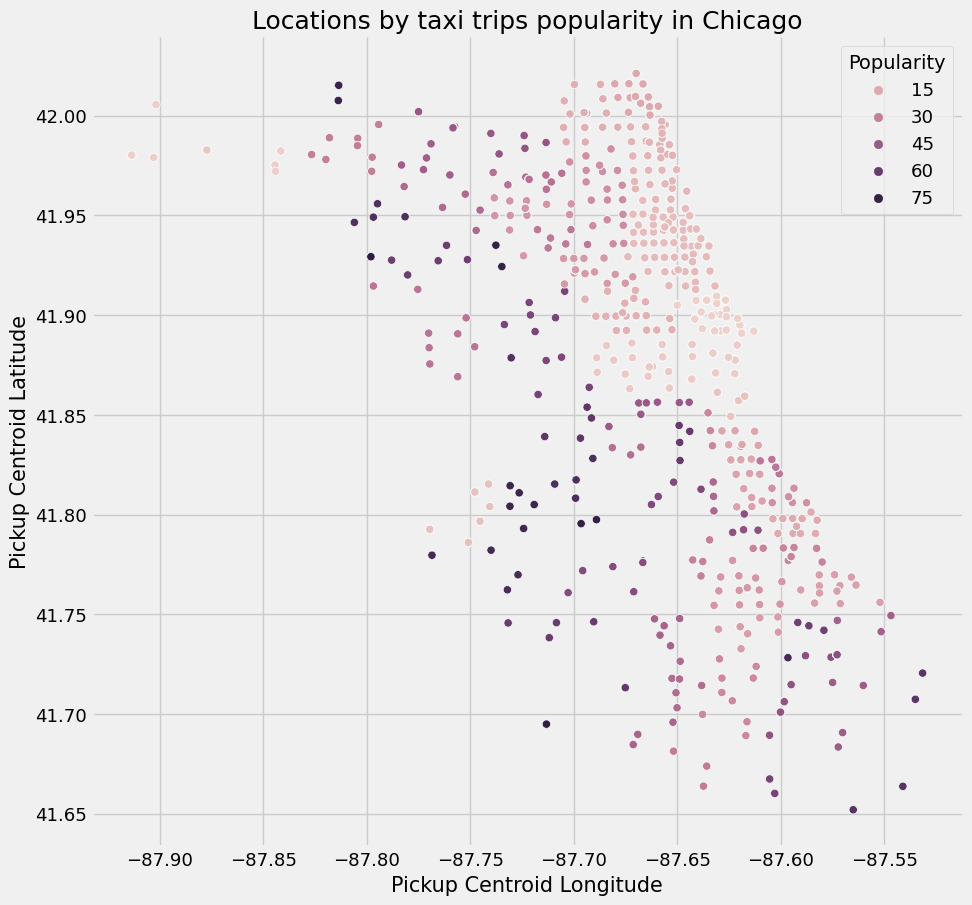

In [52]:
plt.figure(figsize=(10, 10))
geo_plot = sns.scatterplot(
    data=geo_features_pickup,
    y="Pickup Centroid Latitude",
    x="Pickup Centroid Longitude",
    hue="Popularity",
)
plt.title("Locations by taxi trips popularity in Chicago");

Least popular locations seem to predominantly be situated at the edges of the city.

In [53]:
popular_locations_top = popularity.head(5)

In [54]:
unpopular_locations_top = popularity.tail(5)

### Time features for trips count and payment total

For trips count and total hourly revenue, rolling mean and lag features will be added. 
  
*All following data processing is done in Pandas. The dataset was resampled by 1 hour and contains less than 1 million rows, the usage of PySpark is no longer justified.*

In [55]:
counts = grouped.count()
trip_total_aggs = agg_2_sum_and_median.select(["date", "location", "trip_total_agg"])

In [56]:
trips_count = counts.join(trip_total_aggs, on=["date", "location"], how="left")

In [57]:
trips_count = trips_count.toPandas()

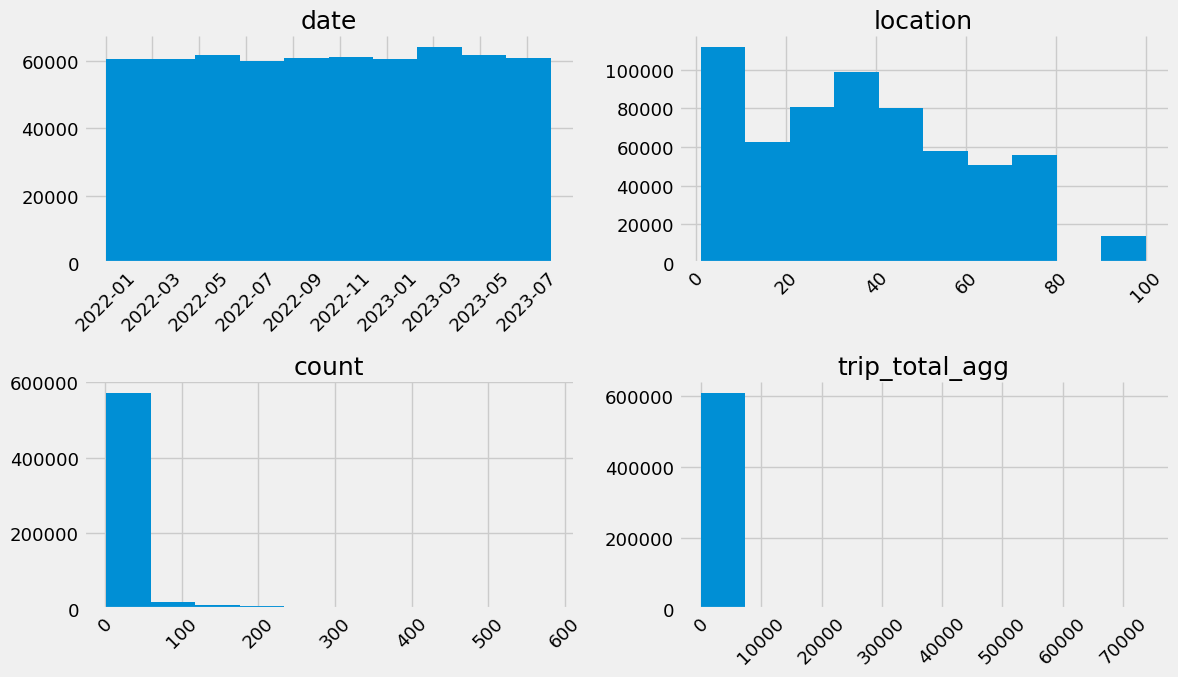

In [58]:
trips_count.hist(figsize=(12, 7), xrot=45)
plt.tight_layout()

Taking a closer look at the taxi trips count:

In [59]:
trips_count_grouped = trips_count.groupby(["date"]).sum().drop("location", axis=1)

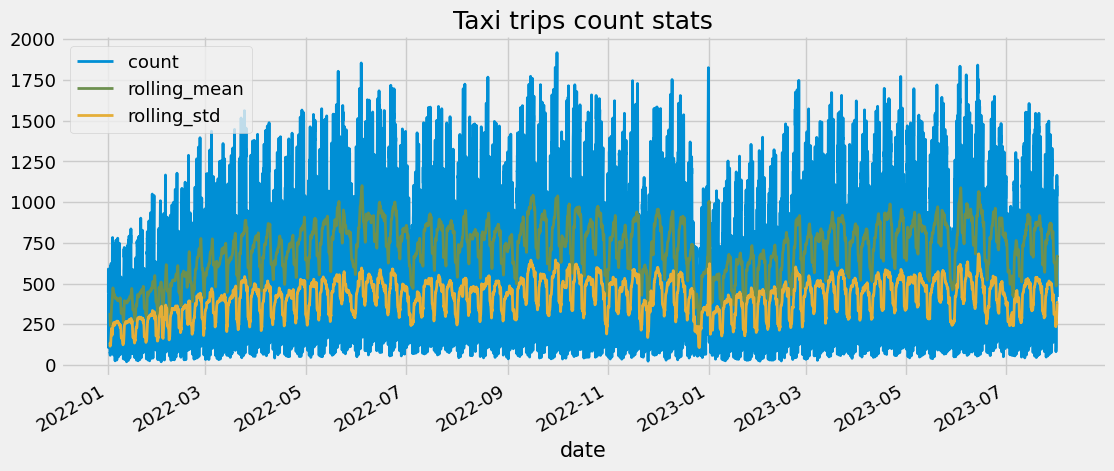

In [60]:
trips_count_grouped["count"].plot(figsize=(12, 5))
trips_count_grouped["count"].shift().rolling(24).mean().plot(color="#6d904f")
trips_count_grouped["count"].shift().rolling(24).std().plot(color="#e5ae38")
plt.title("Taxi trips count stats")
plt.legend(["count", "rolling_mean", "rolling_std"])
plt.show()

The mean and std seem to be non-stationary. There seems to be seasonality in data. STL decomposition will be used to get more valuable information:

In [61]:
trips_count_grouped = trips_count_grouped["count"]  # convert to series
trips_count_grouped = trips_count_grouped.resample("H").sum()  # fake resample to fit in STL

In [62]:
df_decomposed = STL(trips_count_grouped, robust=True).fit()

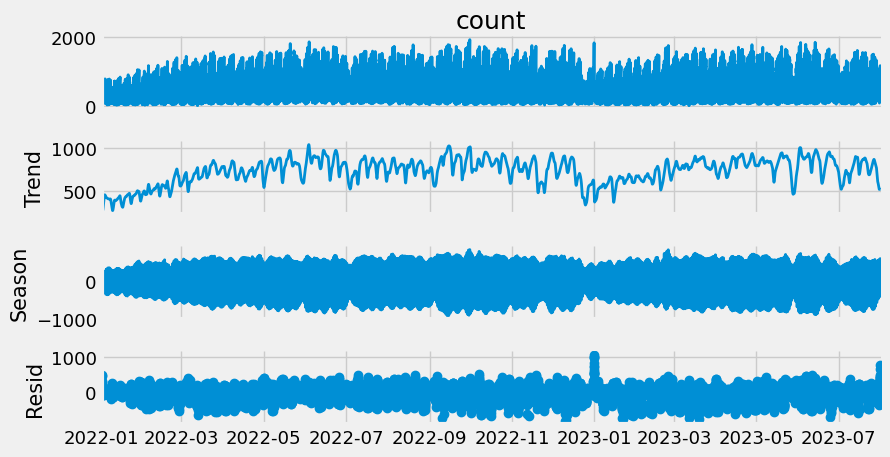

In [63]:
fig = df_decomposed.plot()
fig.set_figwidth(10)

The trend tells us that there is less trips overall in Jan and Feb while in other months there are fluctuations from 500 to 1000 daily trips without explicit trend. There is daily seasonality with mean value that looks stationary. In more detail:

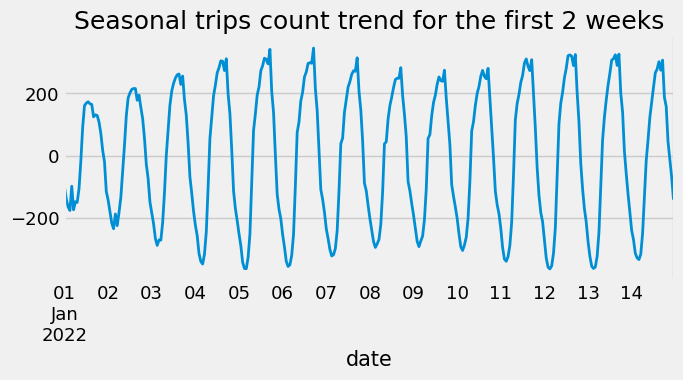

In [64]:
df_decomposed.seasonal.head(24 * 14).plot(figsize=(7, 3))
plt.title("Seasonal trips count trend for the first 2 weeks")
plt.show()

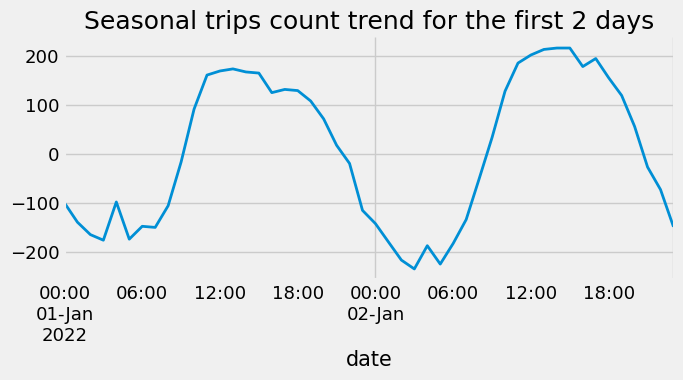

In [65]:
df_decomposed.seasonal.head(2 * 24).plot(figsize=(7, 3))
plt.title("Seasonal trips count trend for the first 2 days")
plt.show()

---

Optimal values for rolling mean size and lag features count will be calculated using custom function.  
It finds the optimal values for these parameters, as well as the necessity to add the STL decomposed features.

The optimal parameters will be calculated using Linear Regression predictions for only one popular community area (location), but will further be used for all other locations as well.

In [66]:
popularity.head(3)

8     1.0
76    2.0
32    3.0
Name: Pickup Community Area, dtype: float64

In [67]:
popular_location = popularity.index.tolist()[2]

In [68]:
# find best params for a popular location

df = (
    trips_count[trips_count["location"] == popular_location]
    .drop("location", axis=1)
    .set_index("date")
    .resample("1H")
    .sum()
)

cv_params = {
    "max_lag": [1, 12, 24, 30, 40, 48, 60, 72, 168],
    "rolling_mean_size": [1, 12, 15, 20, 24, 48, 72],
    "add_decomposed": [False, True],
}

data = TSDataManager(df)
cv_result = data.grid_search(LinearRegression(), cv_params)

100%|██████████| 126/126 [02:44<00:00,  1.31s/it]


In [69]:
# optimal parameters
cv_result

{'best_score_RMSE': 21.107165318757872,
 'best_params': {'max_lag': 168,
  'rolling_mean_size': 12,
  'add_decomposed': True},
 'best_model': LinearRegression()}

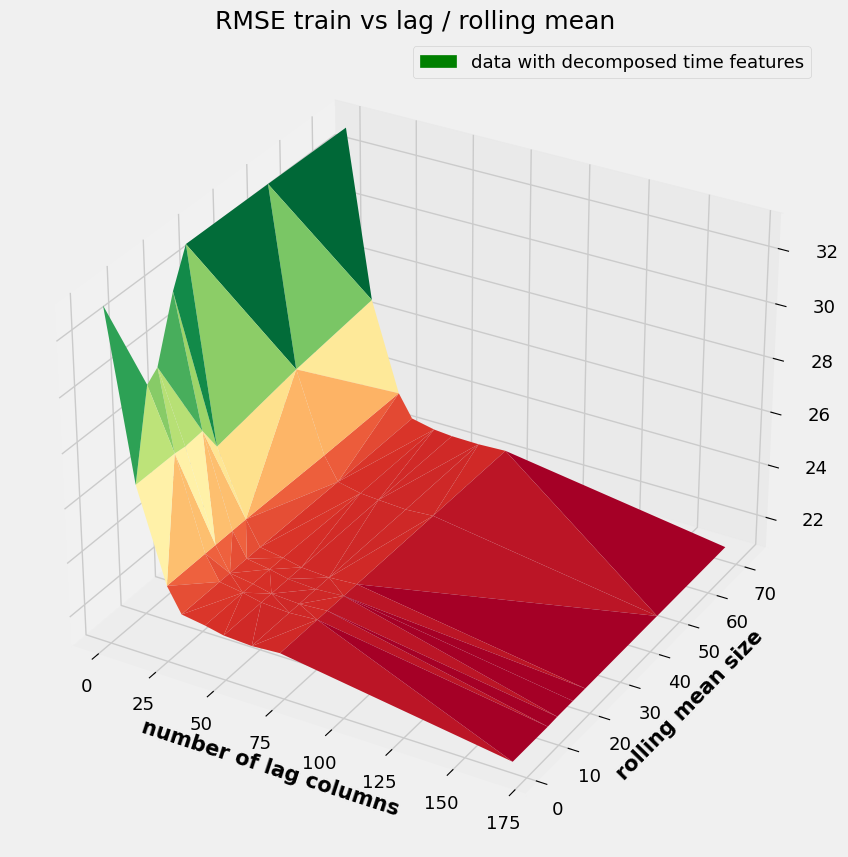

In [70]:
data.plot(plot_non_decomposed=False);

168 lag columns (1 week) and 12 hours rolling mean size (half a day) are the optimal parameters that will be used for feature generation for all locations.  
  
Lag and rolling mean columns for trips count and aggregate hourly revenue will be created separately for every location. Then the resulting dfs for every location will be concatenated.

In [71]:
def make_time_features_by_location(input_df, ts_params):
    """
    Makes lags / rolling mean for every location separately, then concatenates dfs for every location.
    """
    # same functionality is achievable using groupby instead of loop. but no

    dfs_with_added_time_features = dict()
    input_df = input_df.copy()

    for i in tqdm(input_df.location.unique()):
        # resampling is very important as there are missing hours in data
        # the added hours will be later imputed with zeroes
        df = input_df[input_df["location"] == i].drop("location", axis=1).set_index("date").resample("1H").sum()

        data = TSDataManager(df)

        _, modified_df = data.make_features(**ts_params)
        modified_df.insert(0, "location", i)

        dfs_with_added_time_features[i] = modified_df.copy()

    time_features = pd.concat([df for df in dfs_with_added_time_features.values()])
    return time_features

In [72]:
best_ts_params = cv_result["best_params"]
best_ts_params["rolling_mean_size"] = 12

time_features = make_time_features_by_location(trips_count, best_ts_params)

100%|██████████| 78/78 [02:59<00:00,  2.30s/it]


## Machine learning

### Merging dfs and final data preparation

Join the time features and non-time features:

In [73]:
final_df = time_features.merge(
    non_time_features, left_on=["date", "location"], right_on=["date", "location"], how="left"
)

In [74]:
final_df = final_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_ ]+", "", x))  # rename columns to be machine readable
final_df = final_df.loc[:, ~final_df.columns.duplicated()].copy()  # drop duplicate columns, if any
final_df = final_df.set_index("date")

In [75]:
# remove first week containing gaps in lag columns
final_df = final_df[START_DATE:]

Fill the first hour with 0 trips using the data from previous hour, fill all other rows with 0:

In [76]:
final_df = final_df.sort_values(["location", "date"])

The first 0-trip hours will be filled with the values for 2 hours before it - this improves score a bit. This is based on the assumption that the hour before 0 trips is more similar to the hour before it than to a 0-trip hour.

In [77]:
final_df = final_df.fillna(method="ffill", limit=1)  
final_df = final_df.fillna(0)  # fill all other with zeroes

Add an artificial feature that clusters the regions by relatively large prediction error and geographical proximity.

In [78]:
# clusterize regions with worse predictions by geographical proximity

cluster_dict = dict()

pop_dict = {
    1: [11, 12, 15, 17, 18, 20],
    2: [23, 26],
    3: [30, 31],
    4: [47, 50, 51, 52, 54, 55],
    5: [63, 65, 67],
    6: [72, 74],
    7: [56, 76],
}

for key, value in pop_dict.items():
    for el in value:
        cluster_dict[el] = key

In [79]:
final_df["cluster"] = final_df["location"].map(cluster_dict)
final_df["cluster"] = final_df["cluster"].fillna(0)

In [80]:
final_df.head(5)

,location,count,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,count_lag_8,...,tolls_median_lag1,extras_agg_lag1,extras_median_lag1,trip_total_agg_lag1,trip_total_median_lag1,mean_speed_median_lag1,pickup_census_mode_lag1,dropoff_census_mode_lag1,popularity,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,1,2,2.0,1.0,5.0,4.0,3.0,3.0,5.0,12.0,...,0.0,0.0,0.0,43.50,21.75,24.931073,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 01:00:00,1,1,2.0,2.0,1.0,5.0,4.0,3.0,3.0,5.0,...,0.0,0.0,0.0,11.00,5.50,12.610315,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 02:00:00,1,1,1.0,2.0,2.0,1.0,5.0,4.0,3.0,3.0,...,0.0,0.0,0.0,8.00,8.00,11.071429,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 03:00:00,1,2,1.0,1.0,2.0,2.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,11.75,11.75,9.782609,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 04:00:00,1,2,2.0,1.0,1.0,2.0,2.0,1.0,5.0,4.0,...,0.0,0.0,0.0,28.00,14.00,20.388927,1.704901e+10,1.704901e+10,15.0,0.0


### Train/test split

Size of train data is 70%, validation and test data are both 15%.

In [81]:
val_iloc = -int(len(final_df.index.unique()) * 2 * TEST_SIZE)
test_iloc = -int(len(final_df.index.unique()) * TEST_SIZE)

val_index = final_df.index.unique()[val_iloc]
test_index = final_df.index.unique()[test_iloc]

In [82]:
str(val_index)

'2023-02-11 00:00:00'

In [83]:
str(test_index)

'2023-05-07 12:00:00'

In [84]:
X_train = final_df.drop("count", axis=1).loc[: str(val_index)]
y_train = final_df["count"].loc[: str(val_index)]


X_valid = final_df.drop("count", axis=1).loc[str(val_index) : str(test_index)]
y_valid = final_df["count"].loc[str(val_index) : str(test_index)]


X_test = final_df.drop("count", axis=1).loc[str(test_index) :]
y_test = final_df["count"].loc[str(test_index) :]

In [85]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(747006, 416)
(160134, 416)
(159861, 416)


### Getting predictions (Approach I, aggregate predictions)

The first approach is to have 1 model for all data. An ensemble of LGBMRegressor and CatBoost regressor is used for this purpose. Model selection is not performed in this notebook, only the best parameters (providing best score on validation data) are left. **Location, popularity** and **cluster** are handled as categorical features for better results.

In [95]:
gbm_params = {
    "learning_rate": 0.1,
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "max_depth": 20,
    "early_stopping_round": 50,
    "categorical_features": [X_train.columns.get_loc(col) for col in ["location", "popularity", "cluster"]]
}

In [96]:
gbm = lgb.LGBMRegressor(n_jobs=-1, application="regression", metric="mae", **gbm_params)
gbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric="mae", verbose=-1)

preds_gbm = gbm.predict(X_test)
mean_absolute_error(y_test, preds_gbm)

1.7071904835774623

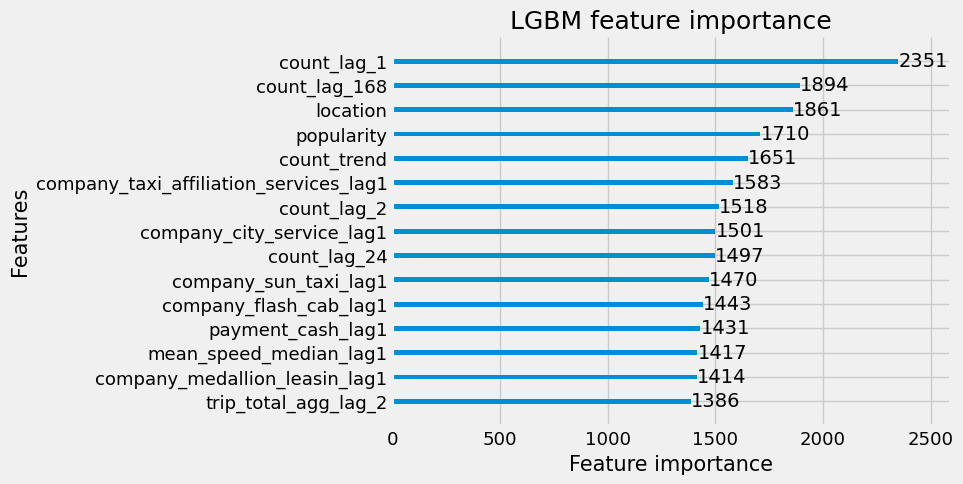

In [97]:
lgb.plot_importance(gbm, max_num_features=15, title="LGBM feature importance")
plt.show()

Most important features for LGBM are trips count for previous hour, trips count a week ago and the trend of trips count from STL decomposition, shift by 1 hour.

In [98]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.2,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 50,
    "boosting_type": "Plain",  # should increase training speed
    "verbose": 500,
    "eval_metric": "MAE",
}

In [99]:
cbr = CatBoostRegressor(**cbr_params)
cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid))

preds_cbr = cbr.predict(X_test)
mean_absolute_error(y_test, preds_cbr)

0:	learn: 7.7580365	test: 8.3306221	best: 8.3306221 (0)	total: 643ms	remaining: 32m 7s
500:	learn: 1.4059157	test: 1.6910141	best: 1.6910141 (500)	total: 4m 35s	remaining: 22m 53s
1000:	learn: 1.2758295	test: 1.6628061	best: 1.6628061 (1000)	total: 9m 18s	remaining: 18m 36s
1500:	learn: 1.2140661	test: 1.6477922	best: 1.6477922 (1500)	total: 13m 47s	remaining: 13m 45s
2000:	learn: 1.1813713	test: 1.6375308	best: 1.6375308 (2000)	total: 18m 23s	remaining: 9m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.633009137
bestIteration = 2340

Shrink model to first 2341 iterations.


1.686232168788733

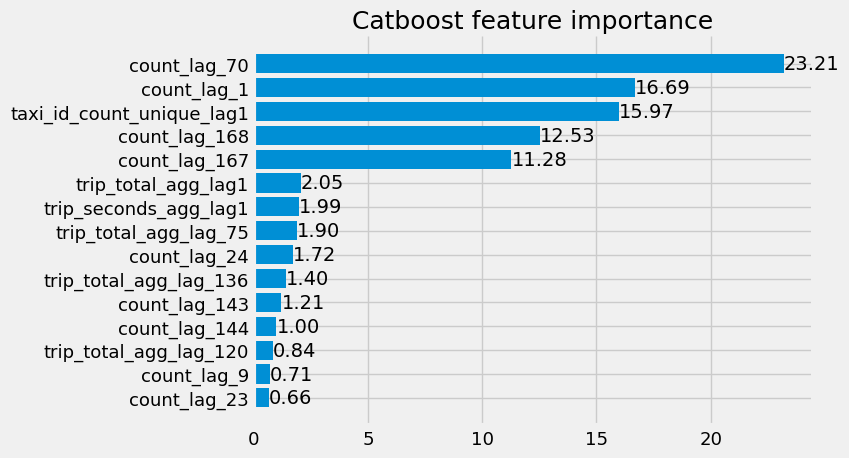

In [100]:
fi = pd.Series(cbr.feature_importances_, index=cbr.feature_names_).sort_values(ascending=False)
fi_short = fi[:15][::-1]

ax = plt.barh(fi_short.index, fi_short.values)
plt.bar_label(ax, fmt="%.2f")
plt.title("Catboost feature importance")
plt.show()

Most important features for CatBoost are trips count for previous hour, trips count a day ago and the count of unique taxi ids for the previous hour.

Getting the final combined prediction:

In [101]:
combined = (0.75 * preds_gbm + 1.25 * preds_cbr) / 2  # the prediction weights are empirical
combined = list(map(lambda x: x if x >= 0 else 0, combined))

All the values less than 0 are zeroed as there can't be less than 0 trips per hour. Final MAE score for the first approach:

In [102]:
mean_absolute_error(y_test, combined)

1.6499367587918887

### Getting predictions (Approach II, separate predictions)

The second approach is to have 1 model for every location (community area). The motivation for implementing this is that with the previous approach the model might underfit due to the training on the whole dataset, and we can eliminate this factor by using a separate prediction for each location.  
Mean MAE for all regions is used as a metric in this case.

In [123]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.2,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 100,
    "boosting_type": "Plain",  # should increase speed
    "logging_level": "Silent",
    "eval_metric": "MAE",
}

In [124]:
gbm_params = {
    "learning_rate": 0.2,  # has no impact
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "early_stopping_round": 50,
    "max_depth": 20,
    "categorical_features": [X_train.columns.get_loc(col) for col in ["location", "popularity", "cluster"]]
}

In [125]:
predictions = []

for i in tqdm(X_train["location"].unique()):
    X_train_subset = X_train[X_train["location"] == i]
    y_train_subset = y_train[X_train["location"] == i]

    X_valid_subset = X_valid[X_valid["location"] == i]
    y_valid_subset = y_valid[X_valid["location"] == i]

    X_test_subset = X_test[X_test["location"] == i]
    y_test_subset = y_test[X_test["location"] == i]

    cbr = CatBoostRegressor(**cbr_params)
    cbr.fit(X_train_subset, y_train_subset, eval_set=(X_valid_subset, y_valid_subset))

    gbm = lgb.LGBMRegressor(metric="mae", **gbm_params)
    gbm.fit(
        X_train_subset,
        y_train_subset,
        eval_set=(X_valid_subset, y_valid_subset),
        eval_metric="mae",
        verbose=-1
    )

    preds_gbm_partial = gbm.predict(X_test_subset)
    preds_cbr_partial = cbr.predict(X_test_subset)

    combined_partial = (0.75 * preds_gbm_partial + 1.25 * preds_cbr_partial) / 2
    combined_partial = list(map(lambda x: x if x >= 0 else 0, combined_partial))

    predictions.append(mean_absolute_error(y_test_subset, combined_partial))

100%|██████████| 78/78 [16:34<00:00, 12.75s/it] 


Final mean MAE:

In [126]:
sum(predictions) / len(predictions)

1.7579721671310444

This approach is faster but the resulting metric looks worse than that for the 1st approach. However, as it is a slightly different metric, it will be fair to compare normalized MAEs for all regions in order to determine a better approach.

### Comparing two approaches

Adding MAEs for every region for the "separate models" approach to a df:

In [127]:
prediction_stats = trips_count.groupby("location").mean()

In [128]:
prediction_stats["preds"] = predictions
prediction_stats["normalized_preds"] = 100 * prediction_stats["preds"] / prediction_stats["count"]

A custom normalized MAE metric (MAE divided by mean trips count in the region) is used for a more fair comparison and identification of outliers in predictions.

Adding MAEs for every region for the "aggregate" (one model) approach to the same df:

In [129]:
agg_preds = X_test.copy()
agg_preds["predictions"] = combined
agg_preds = agg_preds[["location", "predictions"]]
agg_preds["y_test"] = y_test

In [130]:
predictions_agg_method = []

location_idx = [i for i in range(1, 78)]
location_idx.append(100)

for i in location_idx:
    grouped_by_loc = agg_preds[agg_preds["location"] == i]
    predictions_agg_method.append(mean_absolute_error(grouped_by_loc["y_test"], grouped_by_loc["predictions"]))

In [131]:
prediction_stats["preds_aggregate"] = predictions_agg_method
prediction_stats["normalized_preds_aggregate"] = 100 * prediction_stats["preds_aggregate"] / prediction_stats["count"]

Applying function to determine an approach that provides lower MAE:

In [132]:
def define_better_method(row):
    if row["preds"] < row["preds_aggregate"]:
        return "separate"
    else:
        return "aggregate"

In [133]:
prediction_stats["better_method"] = prediction_stats.apply(define_better_method, axis=1)
prediction_stats["better_method"].value_counts()

aggregate    76
separate      2
Name: better_method, dtype: int64

First ("aggregate") approach is better in almost every case. This is also shown by the following figure:

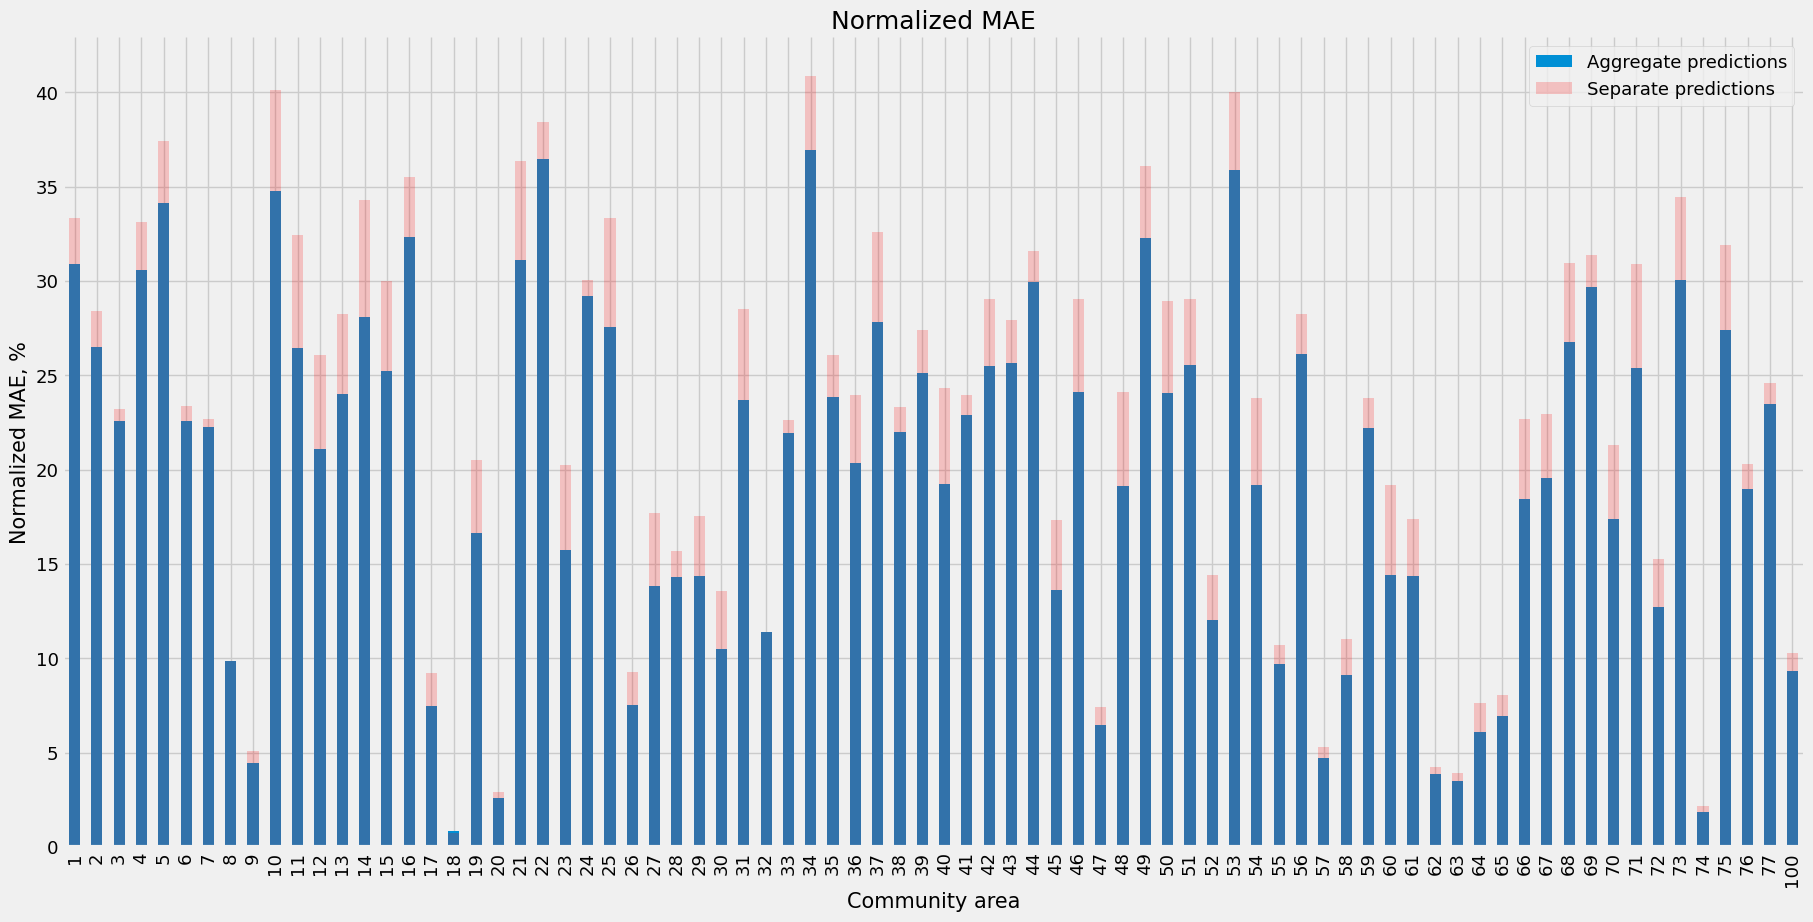

In [134]:
prediction_stats["normalized_preds_aggregate"].plot(kind="bar", title="Normalized MAE")
prediction_stats["normalized_preds"].plot(kind="bar", figsize=(20, 10), alpha=0.2, color="red")

plt.legend(["Aggregate predictions", "Separate predictions"])
plt.ylabel("Normalized MAE, %")
plt.xlabel("Community area");

Let's now sort the community areas by trips count in order to determine how the prediction quality depends on popularity:

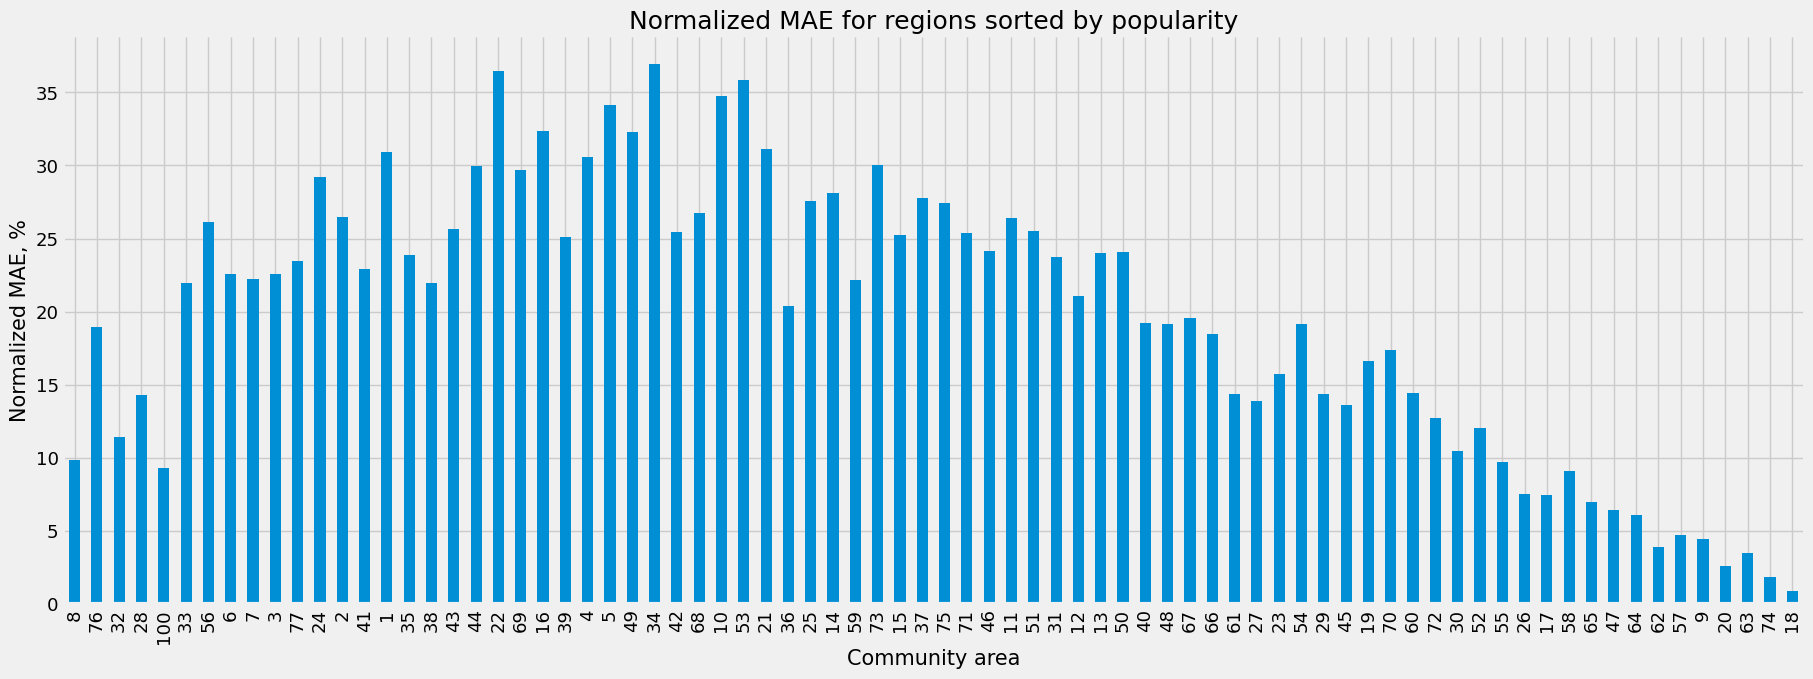

In [135]:
prediction_stats.reindex(popularity.index)["normalized_preds_aggregate"].plot(kind="bar", title="Normalized MAE for regions sorted by popularity", figsize=(20, 7))
plt.ylabel("Normalized MAE, %")
plt.xlabel("Community area");

The model provides overall better predictions for regions with big and low counts of trips. For "interim" regions, the prediction quality is the worst.

## Conclusion

1. A task of predicting the count of taxi trips in Chicago for the next hour was solved using PySpark, Pandas, and gradient boosting algorithms (LightGBM, CatBoost). The approach includes resampling the data by 1 hour and using aggregate functions to get information from each feature (mode, median, sum etc.). A separate module is used to create lags and rolling mean features for trip counts and total hourly payments.
2. Local PySpark cluster was implemented to perform data preprocessing and aggregation for a large dataset (available taxi trips data for 2022 and 2023). The task can further be upscaled by using data for more years.
3. Two approaches were compared: 1 model for all predictions, and a separate model for each community area, with first approach providing significantly better results. Resulting test dataset MAE for predictions with the better approach is 1.59.
4. This notebook can be implemented in an industrial setting for optimizing the number of cars available in every community area of Chicago each hour.

### Potential areas for improvement

1. Understanding the reasons for bad prediction quality in community areas with medium trip counts.
2. Finding a better metric to compare the approaches. The proposed normalized MAE metric may be not optimal for regions where a lot of hours have 0 trips, as the error will be low for such regions.
3. Improving scores by using external data, e. g. data on bank holidays, traffic jams stats, etc.
4. Retraining models on the (training + validation) dataset. Not done in this notebook for the sake of time save.
5. Note: imputing gaps with median for some features has a potential data leak for test data, so the final MAE and normalized MAE scores may look a little better than they would be for real data.
6. ...